# First Approach to Histological Imagen Data Augmentation Using DCGAN  
___

Previous Refereces:
> - [Patching and Data Augmentation for Histological Images]()  
> - [Simple DCNN for histological data classification]()

## Index:
> 1. Loading Packages and Data
> 2. Get Batches
> 3. Placeholders
> 4. Discrimanator
> 5. Generator
> 6. Loss Function
> 7. Adam Optimizer
> 8. Train
> 9. Run Session

## 1. Loading Packages and Data

Firstly we will load all the packages needed to perform this deeplearning technique:

In [1]:
import pickle
import os
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
import pickle

The code is based in the one used in the tutorial "Implementing a Generative Adversarial Network (GAN/DCGAN) to Draw Human Faces".  

Please see the link below:  
https://towardsdatascience.com/implementing-a-generative-adversarial-network-gan-dcgan-to-draw-human-faces-8291616904a

<a href="https://www.youtube.com/watch?v=qbW-X6iW5jE" target="_blank"><img src="https://img.youtube.com/vi/qbW-X6iW5jE/maxresdefault.jpg" 
alt="IMAGE ALT TEXT HERE" width="240" height="180" border="10" /></a>

We will load the treated data performed in the notebook for "Data Preparation and Augmentation". For doing so we will use the function *pickle.load* as below:

In [2]:
pickle_in = open("Train_Data.pickle", "rb")
Train_Data = pickle.load(pickle_in)

In order to double check the type of normalisation we carried out in the previous section we calculate *min* and *max* of the database. as we can see, our data has been normalised from 0 to 1 values, what means we need to be careful with the type of activation function to be used in the final activation layer.

In [3]:
np.max(Train_Data),np.min(Train_Data)

(1.0, 0.007843138)

## 2. Get Batches

This is with any doubt one of trickiest part of the code when we are trying to apply the model to our own data, as most of the training examples that can be found only make reference to the MNIST example, which is not very meaningful as it is pretreated data. In this senction we try to point out how to set the batches, which is not needed when working with the MNIST or CIFAR-10 examples.   
  
The code below will group sections of the matrix to split the database by batches, which is a requirement to apply DCGAN in most of the cases. This formula will be fixed to our database and the only variables that will be required would be tha batch size "*batch_size*" as the idea is change this variable to optimize this process as much as possible.  
  
As in the fucture we will use an *tanh* activation function or that will need to be normalised from -1 to 1. Therefore, will will centralised the data at the end of this step by applying *-0.5*.

In [4]:
def get_batches(batch_size):
    shape = len(Train_Data), IMAGE_WIDTH, IMAGE_HEIGHT, 
    data = Train_Data
    """
    Generate batches
    """
    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = data[current_index:current_index + batch_size]
        current_index += batch_size
        yield data_batch - 0.5

After this step we will start using the tensorflow package:

In [5]:
import tensorflow as tf

We can check our tensorflow version by applying:

In [6]:
print(tf.__version__)

1.4.1


## 3. Placeholder

This is a very straightfoward step in our code. Placeholders are a tensorflow function that works as bridge between our numpy array data (float32) and tensorflow flow format (tensors).

In [7]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

Note: Please notice that the name of the placeholder does not match the name of the variable where it is defined.

## 4. Discriminator

We are going to use a TensorFlow variable scope when defining this network. This helps us in the training process later so we can reuse our variable names for both the discriminator and the generator.

The discriminator network consists of four convolutional layers. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

 ![alt text](https://d3ansictanv2wj.cloudfront.net/page4-515a902921add733ec6550b643b7e4d4.png "Logo Title Text 1")

In [ ]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

## 5. Generator

This network consists of four deconvolutional layers. In here, we are doing the same as in the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

 ![alt text](https://d3ansictanv2wj.cloudfront.net/page5-8bb6a0d5abd4b8660fb3c5d05ed20282.png "Logo Title Text 1")

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

## 6. Loss Functions

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))

    return d_loss, g_loss

## 7. Adam Optimizer

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## 8. Train

In the last step of our preparation, we are writing a small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [12]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    #plt.imshow(helper.images_square_grid(samples))
    #plt.show()

    plt.imshow(np.array((((samples[0])/2)+0.5), np.float32))

Now, we just get our inputs, losses and optimizers which we defined before, call a TensorFlow session and run it batch per batch. 

In [13]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200
shape = len(Train_Data), IMAGE_WIDTH, IMAGE_HEIGHT, 3

In [14]:
# One off as reuse is false
input_real, input_z, _ = model_inputs(shape[1], shape[2], shape[3], z_dim)
d_loss, g_loss = model_loss(input_real, input_z, shape[3])
d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 1.9007
###########################################################
Tensor("input_z:0", shape=(?, 100), dtype=float32) 3
Epoch 2/2... Discriminator Loss: 0.3664... Generator Loss: 3.1264
###########################################################
Tensor("input_z:0", shape=(?, 100), dtype=float32) 3


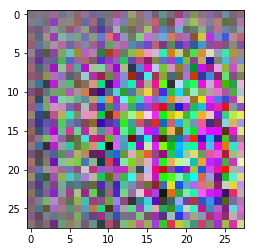

In [15]:
epochs = 2
epoch_i = 0
steps = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch_i in range(epochs):
        for batch_images in get_batches(batch_size):
            batch_images = batch_images * 2
            steps += 1
            #batch_z = np.array(np.random.uniform(-1, 1, size=(batch_size,z_dim)), np.float32)
            batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))
            _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: np.array(batch_z, np.float32)})
            _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: np.array(batch_z, np.float32)})  
            #print("here!")
            if steps % 83 == 0:
                #print("There!")
                # At the end of every 10 epochs, get the losses and print them out
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                
                _ = show_generator_output(sess, 1, input_z, shape[3])

                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g))
                print("###########################################################")
                print (input_z, shape[3])            

In [ ]:
# def show_generator_output(sess, n_images, input_z, out_channel_dim):
z_dim = 0
inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    show_generator_output(sess, 1, input_z, shape[3])